# Generate images with high input fidelity

This cookbook shows how you can leverage the `input_fidelity` parameter, available in the Image API and the Responses image generation tool, to preserve distinctive features from the input.

Setting `input_fidelity="high"` is especially useful when editing images with faces, logos, or any other details that require high fidelity in the output.

If you're not already familiar with image generation using the OpenAI API, we recommend starting with our [introductory image generation cookbook](https://cookbook.openai.com/examples/generate_images_with_gpt_image).


## Set-up

In [ ]:
%pip install pillow openai -U  # (skip if already installed)

In [1]:
import base64, os
from io import BytesIO
from PIL import Image
from IPython.display import display, Image as IPImage
from openai import OpenAI

client = OpenAI()
# Set your API key if not set globally
#client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

In [2]:
folder_path = "imgs"
os.makedirs(folder_path, exist_ok=True)

In [3]:
def resize_img(image, target_w):
    w, h = image.size
    target_h = int(round(h * (target_w / float(w))))
    resized_image = image.resize((target_w, target_h), Image.LANCZOS)
    return resized_image

def edit_img(input_img, prompt):
    result = client.images.edit(
        model="gpt-image-1",
        image=input_img,
        prompt=prompt,
        input_fidelity="high",
        quality="high",
        output_format="jpeg"
    )

    image_base64 = result.data[0].b64_json
    image_bytes = base64.b64decode(image_base64)
    image = Image.open(BytesIO(image_bytes))
    return image

## Precise editing

High input fidelity allows you to make subtle edits to an image without altering unrelated areas. This is ideal for controlled, localized changes.

Example use cases:
- **Item edits:** Change isolated elements (e.g., swap a mug color) while leaving everything else untouched.
- **Element removal:** Cleanly remove an isolated element without changing the rest of the picture.
- **Element addition:** Seamlessly insert new objects into a scene.

Note that the example outputs below are resized and compressed, hence there is a slight difference in quality compared to the 

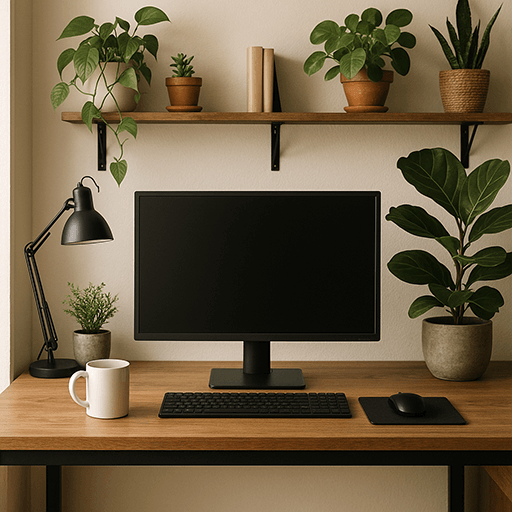

In [4]:
edit_input_path = "imgs/desk.png"
edit_input_img = open(edit_input_path, "rb")
display(IPImage(edit_input_path))

### Item edit

In [5]:
edit_prompt = "Make the mug olive green"
edit_result = edit_img(edit_input_img, edit_prompt)

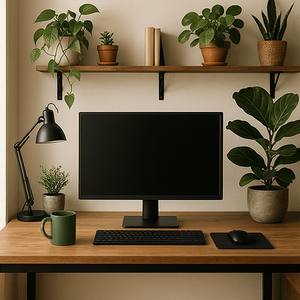

In [42]:
# Display result
edit_resized_result = resize_img(edit_result, 300)
display(edit_resized_result)

### Remove item

In [7]:
remove_prompt = "Remove the mug from the desk"
remove_result = edit_img(edit_input_img, remove_prompt)

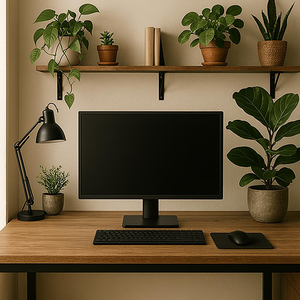

In [43]:
# Display result
remove_resized_result = resize_img(remove_result, 300)
display(remove_resized_result)

### Add item

In [9]:
add_prompt = "Add a post-it note saying 'Be right back!' to the monitor"
add_result = edit_img(edit_input_img, add_prompt)

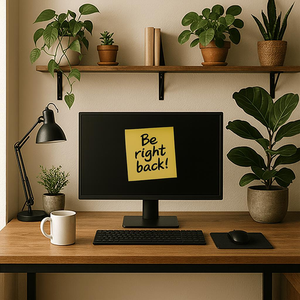

In [44]:
# Display result
add_resized_result = resize_img(add_result, 300)
display(add_resized_result)

## Face preservation


When using high input fidelity, faces are preserved far more accurately than in standard mode. Use this when you need people to remain recognizable across edits.

Example use cases:
- **Image editing:** Edit your photos while preserving facial features.
- **Personalization:** Create avatars that still look like the original person across different backgrounds or styles.
- **Photo merge:** Combine faces from multiple pictures into one image.

**Note:** Currently, while all input images are preserved with high fidelity, only the first one you provide is preserved with extra richness in texture. When working with multiple faces from different photos, try combining all needed faces into a single composite image before sending the request (see the example below).

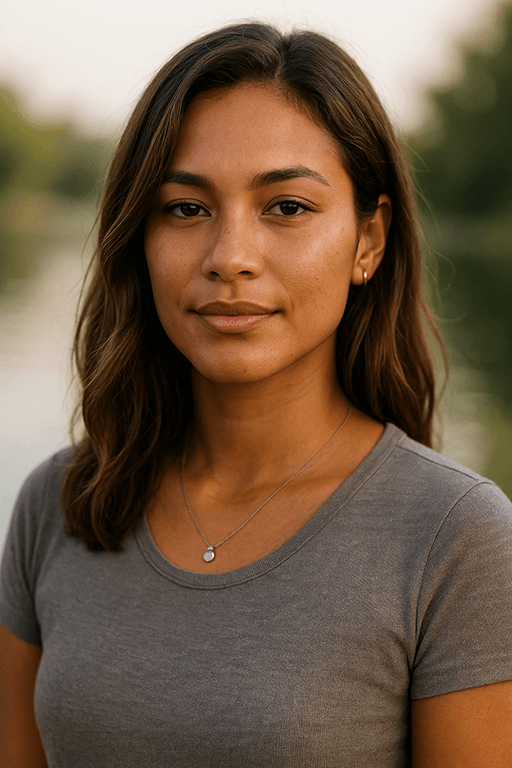

In [11]:
face_input_path = "imgs/woman_portrait.png"
face_input_img = open(face_input_path, "rb")
display(IPImage(face_input_path))

### Image editing

In [12]:
edit_face_prompt = "Add soft neon purple and lime green lighting and glowing backlighting."
edit_face_result = edit_img(face_input_img, edit_face_prompt)

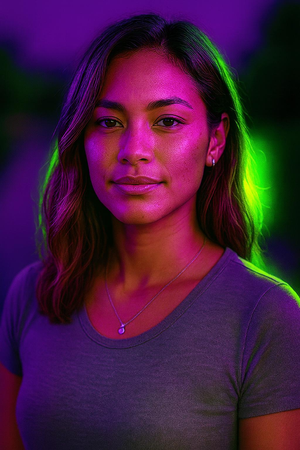

In [45]:
# Display result
edit_face_resized_result = resize_img(edit_face_result, 300)
display(edit_face_resized_result)

### Avatar

In [14]:
avatar_prompt = "Generate an avatar of this person in digital art style, with vivid splash of colors."
avatar_result = edit_img(face_input_img, avatar_prompt)

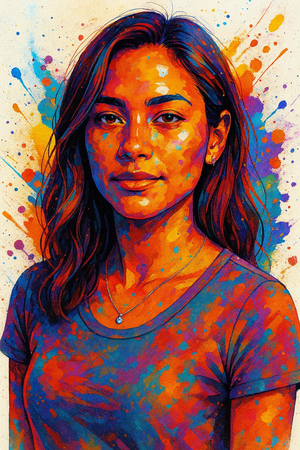

In [46]:
# Display result
avatar_resized_result = resize_img(avatar_result, 300)
display(avatar_resized_result)

### Combine multiple pictures with faces

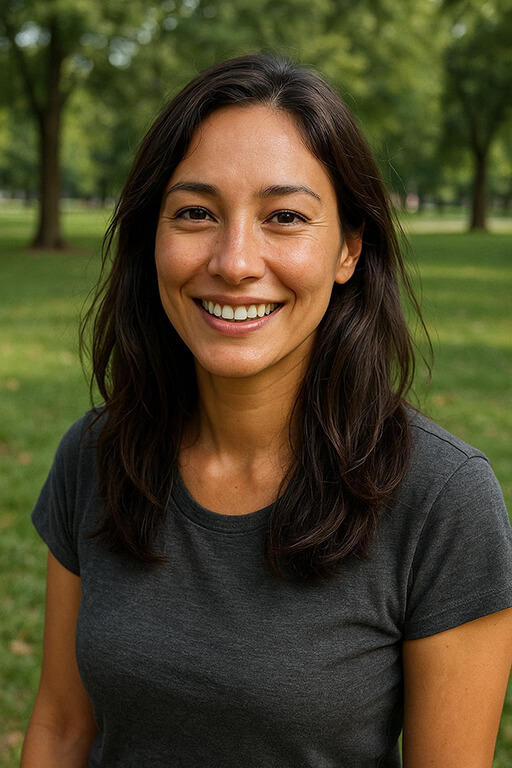

In [16]:
second_woman_input_path = "imgs/woman_smiling.jpg"
second_woman_input_img = open(second_woman_input_path, "rb")
display(IPImage(second_woman_input_path))

In [17]:
def combine_imgs(left_path, right_path, bg_color=(255, 255, 255)):
    
    left_img = Image.open(open(left_path, "rb"))
    right_img = Image.open(open(right_path, "rb"))
    
    # Ensure RGBA for safe pasting (handles transparency)
    left = left_img.convert("RGBA")
    right = right_img.convert("RGBA")

    # Resize right to match left height
    target_h = left.height
    scale = target_h / float(right.height)
    target_w = int(round(right.width * scale))
    right = right.resize((target_w, target_h), Image.LANCZOS)

    # New canvas
    total_w = left.width + right.width
    canvas = Image.new("RGBA", (total_w, target_h), bg_color + (255,))

    # Paste
    canvas.paste(left, (0, 0), left)
    canvas.paste(right, (left.width, 0), right)

    return canvas

In [ ]:
combined_img = combine_imgs(second_woman_input_path, face_input_path)
display(combined_img)

In [20]:
import io

# utility function to convert to bytes
def pil_to_bytes(img, fmt="PNG"):
    buf = io.BytesIO()
    img.save(buf, format=fmt)
    buf.seek(0)
    return buf

combined_img_bytes = pil_to_bytes(combined_img)

In [21]:
combined_prompt = "Put these two women in the same picture, holding shoulders, as if part of the same photo."
combined_result = edit_img(("combined.png", combined_img_bytes, "image/png"), combined_prompt)

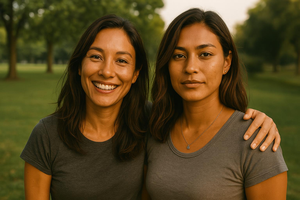

In [47]:
# Display result
combined_resized_result = resize_img(combined_result, 300)
display(combined_resized_result)

## Branding consistency

Sometimes, maintaining brand identity in generated images is essential. High input fidelity ensures that logos and other unique design elements remain true to the original assets.

Example use cases:
- **Marketing assets:** Generate banners or social posts that include your brand logo without distortion.
- **Mockups:** Place your logo or other brand assets into templates or lifestyle scenes without unintended changes.
- **Product photography:** Change a product’s background for different campaigns while keeping the product's details crisp.

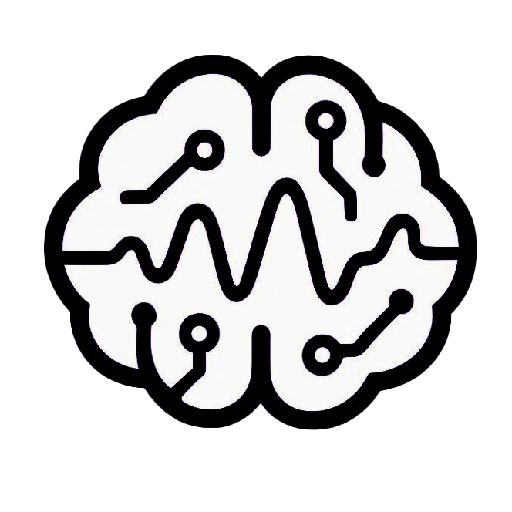

In [23]:
logo_input_path = "imgs/logo.png"
logo_input_img = open(logo_input_path, "rb")
display(IPImage(logo_input_path))

### Marketing assets

In [24]:
marketing_prompt = "Generate a beautiful, modern hero banner featuring this logo in the center. It should look futuristic, with blue & violet hues."
marketing_result = edit_img(logo_input_img, marketing_prompt)

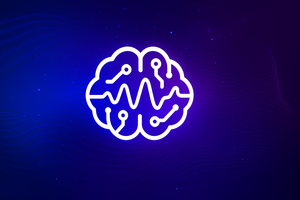

In [48]:
# Display result
marketing_resized_result = resize_img(marketing_result, 300)
display(marketing_resized_result)

### Mockups

In [26]:
mockup_prompt = "Generate a highly realistic picture of a hand holding a tilted iphone, with an app on the screen that showcases this logo in the center with a loading animation below"
mockup_result = edit_img(logo_input_img, mockup_prompt)

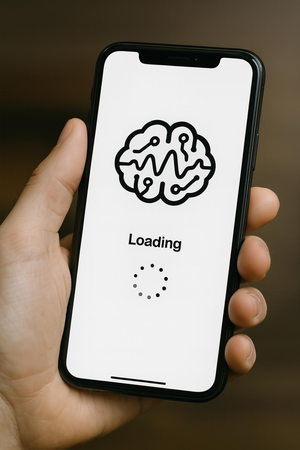

In [49]:
# Display result
mockup_resized_result = resize_img(mockup_result, 300)
display(mockup_resized_result)

### Product photography

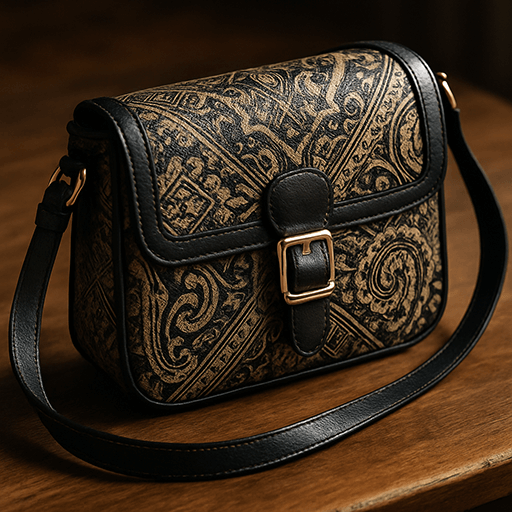

In [28]:
bag_input_path = "imgs/bag.png"
bag_input_img = open(bag_input_path, "rb")
display(IPImage(bag_input_path))

In [29]:
product_prompt = "Generate a beautiful ad with this bag in the center, on top of a dark background with a glowing halo emanating from the center, behind the bag."
product_result = edit_img(bag_input_img, product_prompt)

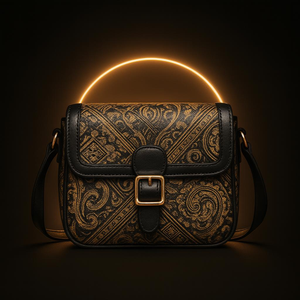

In [50]:
# Display result
product_resized_result = resize_img(product_result, 300)
display(product_resized_result)

## Fashion & Product Retouching


E-commerce and fashion often require editing outfits or product details without compromising realism. High input fidelity ensures fabric textures, patterns, and logos remain consistent.

Example use cases:
- **Outfit variations:** Change the color or style of clothing on a model photo.
- **Accessory addition:** Add jewelry, hats, or other accessories to a model photo without altering their pose or face.
- **Product extraction:** Show the same product or outfit in new settings while keeping details intact.

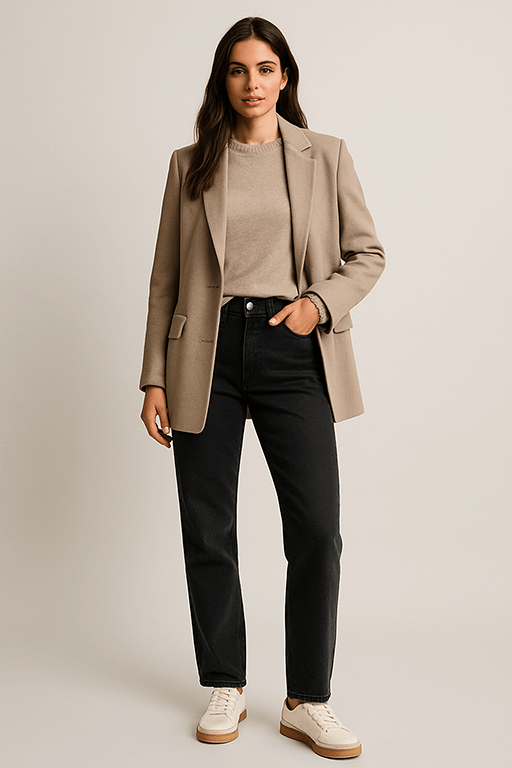

In [31]:
model_input_path = "imgs/model.png"
model_input_img = open(model_input_path, "rb")
display(IPImage(model_input_path))

### Outfit variations

In [32]:
variation_prompt = "Edit this picture so that the model wears a blue tank top instead of the coat and sweater."
variation_result = edit_img(model_input_img, variation_prompt)

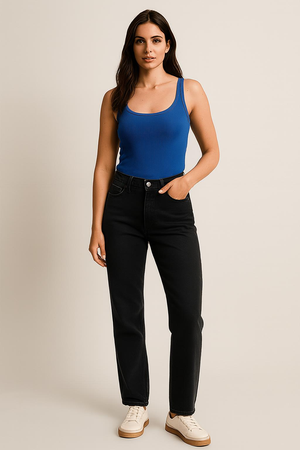

In [51]:
# Display result
variation_resized_result = resize_img(variation_result, 300)
display(variation_resized_result)

### Accessory addition

In this example, we'll combine 2 input images. The image containing the face should be provided as the first input as more details are retained from the first image.

In [34]:
input_imgs = [('model.png',
                 open('imgs/model.png', 'rb'),
                 'image/png'),
    ('bag.png', open('imgs/bag.png', 'rb'),'image/png'),
]

In [35]:
accessory_prompt = "Add the crossbody bag to the outfit."
accessory_result = edit_img(input_imgs, accessory_prompt)

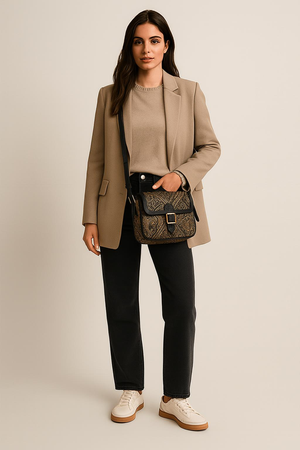

In [52]:
# Display result
accessory_resized_result = resize_img(accessory_result, 300)
display(accessory_resized_result)

### Product extraction

In [37]:
extraction_prompt = "Generate a picture of this exact same jacket on a white background"
extraction_result = edit_img(model_input_img, extraction_prompt)

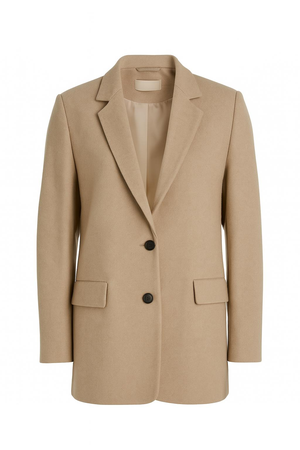

In [53]:
# Display result
extraction_resized_result = resize_img(extraction_result, 300)
display(extraction_resized_result)

## Wrapping up

In this cookbook, we covered how to enable high input fidelity to better preserve important visual details from input images.

Use the example use cases above as inspiration, and try the parameter with your own images to see where high input fidelity makes the biggest difference.

Keep in mind that high input fidelity consumes more image input tokens than the default. Also, while all input images are processed with high input fidelity, the first image in the list preserves the finest detail and richest texture, which is especially important for faces.

Happy building!